## **SKENARIO 1: Klasifikasi KNN - Dimensional Reduction**

## **IMPORT LIBRARY**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix)
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## **DATA LOADING**

In [160]:
# Load dan read data
url_train = "https://drive.google.com/uc?export=download&id=1mwBc1Xbdp5vezgcQLi-BWcsaVNxiqblv"
url_test = "https://drive.google.com/uc?export=download&id=1nSQr83pGwZQ-ShLgrDWH0AoPEi3E5FgF"
url_label = "https://drive.google.com/uc?export=download&id=169-NXQYAKyntsfhcEjzWc0oNB4dD4DkQ"

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_label = pd.read_csv(url_label)

In [161]:
# Menggabungkan fitur train dan label 
df = pd.concat([df_train, df_label], axis=1)
print(f"Dataset Loaded\nDimensi: {df.shape}")

Dataset Loaded
Dimensi: (3817, 17)


## **PREPROCESSING**

### - **Feature Engineering**

In [162]:
def feature_engineering(df_in):
    REF_YEAR = 2025
    REF_DATE = datetime(2025, 12, 31)

    df_out = df_in.copy()
    
    # 1. Fix Date Type
    df_out['tanggal_menjadi_anggota'] = pd.to_datetime(df_out['tanggal_menjadi_anggota'], errors='coerce')
    
    # 2. Feature: Umur
    df_out['umur'] = REF_YEAR - df_out['tahun_kelahiran']
    
    # 3. Feature: Lama Bergabung (Hari)
    df_out['lama_bergabung_hari'] = (REF_DATE - df_out['tanggal_menjadi_anggota']).dt.days
    
    # 4. Feature: Total Belanja
    col_belanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
    df_out[col_belanja] = df_out[col_belanja].fillna(0)
    df_out['total_belanja'] = df_out[col_belanja].sum(axis=1)

    # 5. Rata-rata belanja per kategori
    df_out['avg_belanja'] = df_out['total_belanja'] / 4

    # 6. Rasio belanja protein
    df_out['rasio_protein'] = (
        df_out['belanja_daging'] + df_out['belanja_ikan']
    ) / (df_out['total_belanja'] + 1)
    
    # Drop kolom mentah
    df_out.drop(columns=['tahun_kelahiran', 'tanggal_menjadi_anggota'], inplace=True, errors='ignore')
    
    return df_out

df_eng = feature_engineering(df)
print(f"Feature Engineering Selesai\nDimensi: {df_eng.shape}")

Feature Engineering Selesai
Dimensi: (3817, 20)


### - **Data Cleaning**

In [163]:
# Ganti noise '5' dengan NaN agar dianggap missing value
df_clean = df_eng.copy()

cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    df_clean[col] = df_clean[col].replace('5', np.nan)

In [164]:
# Memisahkan Fitur (X) dan Target (y)
target_col = 'jumlah_promosi'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [165]:
# Melakukan Split data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Done. \nTrain Shape: {X_train_raw.shape}, Val Shape: {X_val_raw.shape}")

Data Split Done. 
Train Shape: (3053, 19), Val Shape: (764, 19)


In [166]:
X_train_clean = X_train_raw.copy()
X_val_clean = X_val_raw.copy()

In [167]:
# Imputasi Missing Values

# Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
X_train_clean[num_cols] = imputer_num.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = imputer_num.transform(X_val_clean[num_cols])

# Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = imputer_cat.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = imputer_cat.transform(X_val_clean[cat_cols])


X_train_imp = pd.DataFrame(X_train_clean, columns=X_train_clean.columns, index=X_train_raw.index)
X_val_imp = pd.DataFrame(X_val_clean, columns=X_val_clean.columns, index=X_val_raw.index)

print("Missing Value Imputation Selesai")

Missing Value Imputation Selesai


In [168]:
X_train_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

In [169]:
X_val_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

### - **FEATURE TRANSFORMATION**

In [170]:
# Melakukan encoding
X_train_enc = X_train_imp.copy()
X_val_enc = X_val_imp.copy()

# Ordinal Mapping (Pendidikan)
education_map = {'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
X_train_enc['pendidikan'] = X_train_enc['pendidikan'].map(education_map)
X_val_enc['pendidikan'] = X_val_enc['pendidikan'].map(education_map)

# One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoding selesai")

Encoding selesai


In [171]:
# Handling Outliers 
X_train_out = X_train_enc.copy()
X_val_out = X_val_enc.copy()

def get_iqr_bounds(series, factor):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return lower_bound, upper_bound


outlier_summary = []

num_cols = X_train_out.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    mild_l, mild_u = get_iqr_bounds(X_train_out[col], 1.5)
    ext_l, ext_u = get_iqr_bounds(X_train_out[col], 3)
    vext_l, vext_u = get_iqr_bounds(X_train_out[col], 5)

    outlier_summary.append({
        "feature": col,
        "mild_outlier_pct (%)":
            ((X_train_out[col] < mild_l) | (X_train_out[col] > mild_u)).mean() * 100,
        "extreme_outlier_pct (%)":
            ((X_train_out[col] < ext_l) | (X_train_out[col] > ext_u)).mean() * 100,
        "very_extreme_outlier_pct (%)":
            ((X_train_out[col] < vext_l) | (X_train_out[col] > vext_u)).mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,feature,mild_outlier_pct (%),extreme_outlier_pct (%),very_extreme_outlier_pct (%)
0,pendidikan,2.325581,0.000000,0.000000
1,pendapatan,0.196528,0.000000,0.000000
2,jumlah_anak_balita,0.000000,0.000000,0.000000
3,jumlah_anak_remaja,0.000000,0.000000,0.000000
4,terakhir_belanja,0.000000,0.000000,0.000000
5,belanja_buah,7.402555,1.113659,0.000000
6,belanja_daging,4.192597,0.360301,0.000000
7,belanja_ikan,6.583688,0.425811,0.000000
8,belanja_kue,8.385195,1.244677,0.032755
9,pembelian_diskon,3.897805,0.458565,0.098264


In [172]:
cols_to_winsor = outlier_df.loc[
    outlier_df["mild_outlier_pct (%)"] > 1,
    "feature"
].tolist()

winsor_limits = {}

for col in cols_to_winsor:
    lower, upper = get_iqr_bounds(X_train_out[col], factor=1.5)
    winsor_limits[col] = (lower, upper)

for col, (lower, upper) in winsor_limits.items():
    X_train_out[col] = X_train_out[col].clip(lower, upper)
    X_val_out[col] = X_val_out[col].clip(lower, upper)

print("Handling outliers selesai")

Handling outliers selesai


In [173]:
# Melakukan Scaling
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_out),
    columns=X_train_out.columns,
    index=X_train_out.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_out),
    columns=X_val_out.columns,
    index=X_val_out.index
)

print("Scaling selesai")

Scaling selesai


In [174]:
X_train_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,0.0,-0.059931,0.0,1.0,0.395349,0.119889,0.053880,-0.121824,-0.288280,1.5,0.00,0.4,0.0,0.647059,0.0,-0.035931,-0.035931,0.371332,0.0,0.0,0.0,1.0,0.0
2044,0.0,0.000000,0.0,0.0,-0.813953,-0.049365,-0.303887,-0.269279,0.004037,0.0,-0.25,-0.6,0.0,-0.647059,0.0,-0.279728,-0.279728,-2.111294,0.0,0.0,0.0,1.0,0.0
644,2.0,0.845660,0.0,0.0,-0.465116,1.002973,1.531412,1.050619,2.110431,0.0,0.00,1.0,0.0,0.941176,0.0,1.354978,1.354978,0.026954,0.0,0.0,0.0,0.0,0.0
3218,0.0,-0.194915,0.0,2.0,0.372093,2.276619,0.569333,1.109597,2.253822,0.5,1.25,1.4,0.0,-0.176471,0.0,0.860978,0.860978,-1.013320,0.0,0.0,1.0,0.0,0.0
3393,0.0,0.565823,0.0,0.0,-0.883721,1.535780,0.236781,0.974424,0.400573,0.0,1.50,-0.2,0.0,0.470588,0.0,0.387935,0.387935,-0.549663,0.0,0.0,0.0,0.0,1.0


In [175]:
X_val_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2561,0.0,0.035550,0.0,1.0,0.325581,-0.220569,-0.061735,-0.242340,0.164422,-0.5,0.50,1.0,0.0,0.941176,0.0,-0.116517,-0.116517,-0.117015,0.0,0.0,0.0,1.0,0.0
1425,0.0,0.570072,0.0,0.0,-0.720930,2.276619,0.762130,0.731540,0.982068,-1.0,1.50,-0.2,0.0,0.117647,0.0,0.865555,0.865555,-0.647270,0.0,0.0,1.0,0.0,0.0
2185,0.0,-1.143808,0.0,0.0,-1.069767,-0.103828,-0.286680,-0.124650,-0.271442,-0.5,-1.00,-0.8,0.0,-1.176471,0.0,-0.278690,-0.278690,-0.698257,0.0,0.0,0.0,0.0,1.0
2519,0.0,-0.548137,1.0,0.0,0.930233,-0.143374,-0.241610,-0.101679,-0.316135,-0.5,0.25,-0.4,0.0,-0.294118,0.0,-0.253056,-0.253056,0.225926,0.0,0.0,0.0,0.0,1.0
3045,0.0,0.531087,0.0,0.0,1.000000,1.937587,1.101438,0.699243,2.253822,-0.5,1.25,0.4,0.0,-0.941176,0.0,1.119365,1.119365,-0.479235,0.0,0.0,1.0,0.0,0.0


### - **FEATURE SELECTION**

In [203]:
pca = PCA(n_components=0.95, whiten=False, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [204]:
# fig = plt.figure(figsize=(12, 10))
# ax = fig.add_subplot(111, projection='3d')

# sc = ax.scatter(
#     X_train_pca[:, 0],
#     X_train_pca[:, 1],
#     X_train_pca[:, 2],
#     c=y_train,
#     cmap='tab10',
#     alpha=0.7
# )

# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
# ax.set_title('3D PCA Visualization')

# plt.colorbar(sc, label='Jumlah Promosi')
# plt.show()

In [205]:
pca_cols = [f"PCA_{i+1}" for i in range(X_train_pca.shape[1])]

X_train_final = pd.DataFrame(
    X_train_pca,
    columns=pca_cols,
    index=X_train_scaled.index
)

X_val_final = pd.DataFrame(
    X_val_pca,
    columns=pca_cols,
    index=X_val_scaled.index
)

# Menampilkan explained variance ratio
explained_var = pca.explained_variance_ratio_
cum_explained_var = explained_var.cumsum()

for i, (var, cum_var) in enumerate(zip(explained_var, cum_explained_var), start=1):
    print(f"PC{i}: {var:.4f} | Cumulative: {cum_var:.4f}")

PC1: 0.3609 | Cumulative: 0.3609
PC2: 0.1197 | Cumulative: 0.4807
PC3: 0.0865 | Cumulative: 0.5671
PC4: 0.0717 | Cumulative: 0.6388
PC5: 0.0540 | Cumulative: 0.6928
PC6: 0.0443 | Cumulative: 0.7371
PC7: 0.0422 | Cumulative: 0.7793
PC8: 0.0369 | Cumulative: 0.8162
PC9: 0.0339 | Cumulative: 0.8501
PC10: 0.0310 | Cumulative: 0.8811
PC11: 0.0288 | Cumulative: 0.9099
PC12: 0.0272 | Cumulative: 0.9371
PC13: 0.0181 | Cumulative: 0.9552


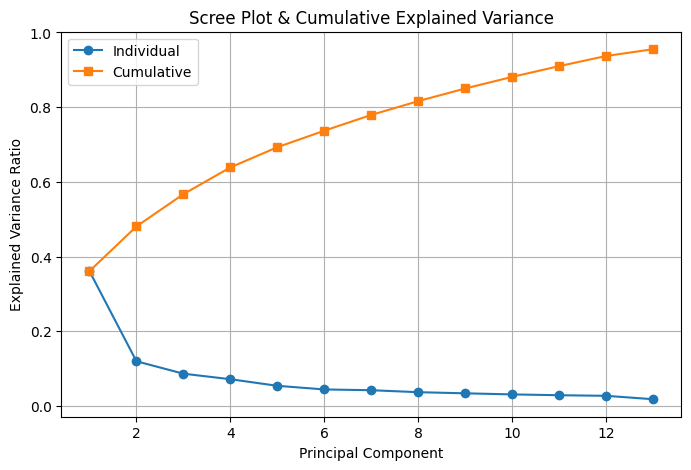

In [206]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, marker='s')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot & Cumulative Explained Variance')
plt.legend(['Individual', 'Cumulative'])
plt.grid(True)
plt.show()

In [207]:
X_train_final.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
700,-1.049594,1.223980,0.681979,-0.886100,0.181436,1.001235,0.028948,0.422050,0.234691,-0.448584,0.034250,-0.213478,0.110969
2044,-1.478036,-1.430130,0.687499,0.755429,-0.196648,-0.267128,-0.669666,0.922507,-0.107831,-0.440779,0.121993,0.328079,0.013598
644,2.864619,1.276039,-0.142699,1.074879,-0.844185,0.127335,-0.625702,-0.252646,0.230647,0.004563,0.525201,0.602310,-0.450580
3218,2.206919,-0.037536,2.400929,0.239011,0.026343,-0.529807,0.603392,-0.547549,0.493222,-0.507765,-0.238681,0.027011,1.093285
3393,0.939426,-0.064147,0.953195,0.101337,0.775928,-0.857833,-0.917966,-0.191002,-1.007301,0.403740,0.086173,-0.878956,-0.012599


In [208]:
X_val_final.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13
2561,-0.641487,0.460275,0.096476,0.263386,1.507398,0.520890,0.140023,0.413796,0.610065,-0.497645,0.582383,0.116665,-0.111598
1425,2.026311,-0.651961,0.578887,0.631457,0.887930,-1.056710,-0.291743,-0.367228,-1.248013,-0.326334,-0.856372,-0.034431,0.210213
2185,-1.869181,-1.615082,-0.828881,0.093082,-0.764094,-0.628487,-0.791916,0.000366,-0.262552,0.124093,0.316264,-0.450149,0.229900
2519,-1.479697,-0.368094,-0.676917,-0.248031,0.331263,-0.190995,0.980451,-0.147727,-0.439697,0.800060,0.371074,-0.528679,-0.236826
3045,2.677361,-0.717034,0.833830,0.096569,-0.015907,-0.956947,1.578348,-0.195105,-0.354600,-0.069991,-0.294938,0.527132,0.238161


## **MANUAL CALCULATION**

In [209]:
train_sample = X_train_final.iloc[:5]
val_sample = X_val_final.iloc[:1]

In [210]:
dists = []
for i in range(len(train_sample)):
    # Euclidean Distance
    d = np.linalg.norm(train_sample.iloc[i] - val_sample.iloc[0])
    dists.append(d)

In [211]:
# untuk k=3
manual_res = pd.DataFrame({
    'Train_Idx': train_sample.index, 
    'Dist': dists, 
    'Label': y_train.iloc[:5].values
}).sort_values('Dist')
manual_res.head(3)

,Train_Idx,Dist,Label
0,700,2.239985,4
1,2044,3.177251,1
4,3393,3.482991,4


## **MODELING**


Mencari nilai K terbaik...
Best K: 1, Best Metric: euclidean, Best Weights: distance dengan akurasi: 0.6296


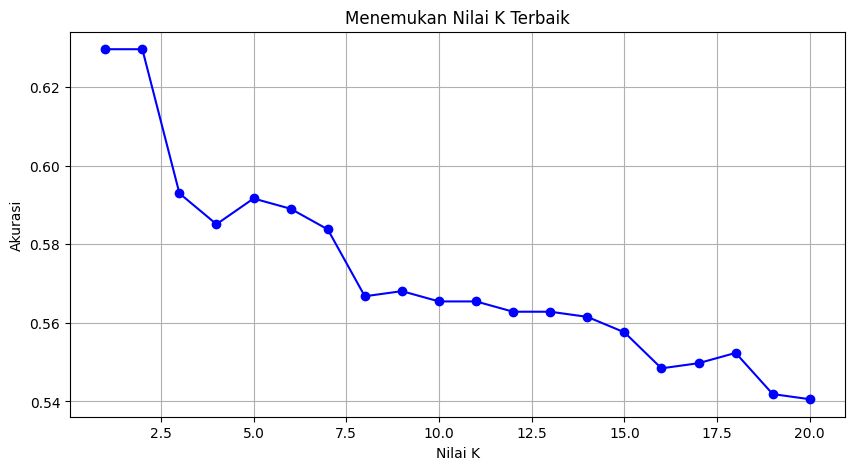

In [212]:
# Menentukan Best parameter K
best_acc = 0
best_k = 1
accuracies = []

print("\nMencari nilai K terbaik...")
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_final, y_train)

    y_pred = knn.predict(X_val_final)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        best_k = k
        best_metric = knn.metric
        best_weights = knn.weights
    


print(f"Best K: {best_k}, Best Metric: {best_metric}, Best Weights: {best_weights} dengan akurasi: {best_acc:.4f}")

# Visualisasi K
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), accuracies, marker='o', linestyle='-', color='b')
plt.title('Menemukan Nilai K Terbaik')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')
plt.grid(True)
plt.show()

In [213]:
# Training
knn_final = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights, metric=best_metric)
knn_final.fit(X_train_final, y_train)
y_pred = knn_final.predict(X_val_final)

## **EVALUATION**


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       195
           1       0.53      0.41      0.46       120
           2       0.57      0.59      0.58        79
           3       0.65      0.75      0.70        84
           4       0.65      0.85      0.74        91
           5       0.70      0.83      0.76       120
           6       0.62      0.67      0.64        75

    accuracy                           0.63       764
   macro avg       0.62      0.66      0.63       764
weighted avg       0.62      0.63      0.62       764



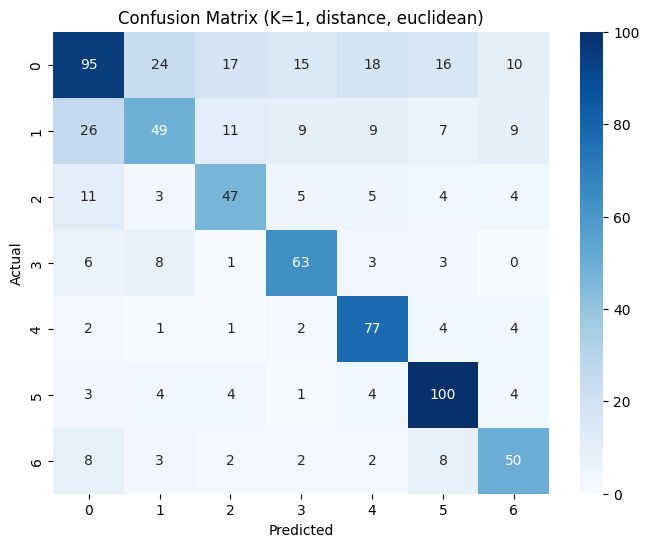

In [214]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (K={best_k}, distance, {best_metric})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **HYPERPARAMETER TUNNING**

In [215]:
print("\n" + "="*40)
print("MEMULAI PENCARIAN PARAMETER TERBAIK...")
print("="*40)

best_score = 0
best_k = 0
best_weight = ''
best_metric = ''

# K dari 1 sampai 30
# weight: uniform (sama rata) dan distance (yang dekat lebih berpengaruh)
# metric: euclidean, manhattan, minkowski
for k in range(1, 31):
    for weight in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan', 'minkowski']:
            knn_tuning = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            knn_tuning.fit(X_train_final, y_train)
            score = knn_tuning.score(X_val_final, y_val)
            
            if score > best_score:
                best_score = score
                best_k = k
                best_weight = weight
                best_metric = metric

print(f"Parameter Terbaik Ditemukan:")
print(f"  - K (Jumlah Tetangga): {best_k}")
print(f"  - Weights (Bobot): {best_weight}")
print(f"  - Metric (Jarak): {best_metric}")
print(f"  - Akurasi Tertinggi: {best_score:.4f}")


MEMULAI PENCARIAN PARAMETER TERBAIK...
Parameter Terbaik Ditemukan:
  - K (Jumlah Tetangga): 1
  - Weights (Bobot): uniform
  - Metric (Jarak): euclidean
  - Akurasi Tertinggi: 0.6296



Classification Report (Model Optimal):
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       195
           1       0.53      0.41      0.46       120
           2       0.57      0.59      0.58        79
           3       0.65      0.75      0.70        84
           4       0.65      0.85      0.74        91
           5       0.70      0.83      0.76       120
           6       0.62      0.67      0.64        75

    accuracy                           0.63       764
   macro avg       0.62      0.66      0.63       764
weighted avg       0.62      0.63      0.62       764



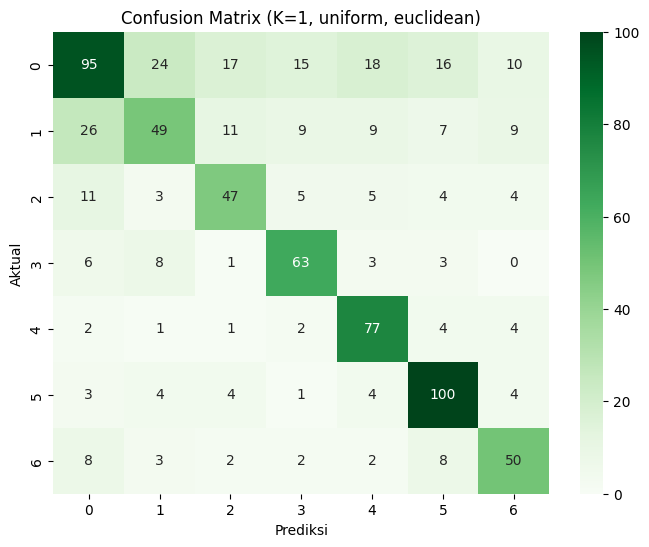

In [216]:
# evaluasi model dengan parameter terbaik
final_model = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight, metric=best_metric)
final_model.fit(X_train_final, y_train)
final_pred = final_model.predict(X_val_final)

print("\nClassification Report (Model Optimal):")
print(classification_report(y_val, final_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, final_pred), annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (K={best_k}, {best_weight}, {best_metric})')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()